# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
# Import the Obspy modules that will be useful to download seismic data
# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal as signal


# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [2]:
# answer below
# Download seismic data
network = 'XH'
station = 'DR01'
channel = 'LHN'
Tstart = UTCDateTime(2015,1,1)
Tend = UTCDateTime(2015,3,31)
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

# call to download the specific data: earthquake waveforms
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.merge(); Z.detrend(type='linear'); Z[0].taper(max_percentage=0.05);Z[0].remove_response()

XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-03-31T00:00:00.000000Z | 1.0 Hz, 7689601 samples

In [3]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

89


Text(0, 0.5, 'Velocity (m/s)')

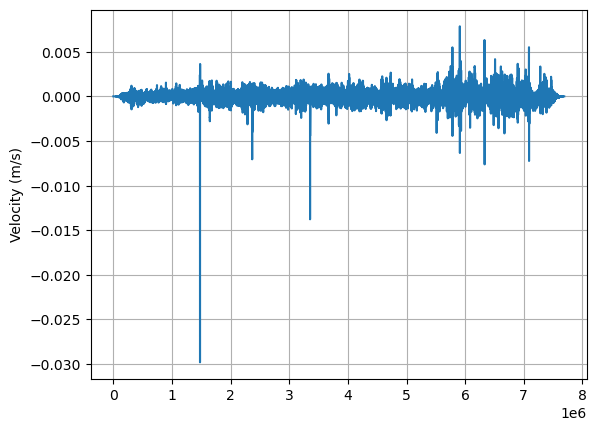

In [4]:
# plot raw data
plt.plot(Z[0].data);plt.grid(True);plt.ylabel('Velocity (m/s)')

**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [3]:
# sampling rate of the data:
fs = Z[0].stats.sampling_rate
z=np.asarray(Z[0].data)
t=np.arange(0.,len(z),1./fs)

In [4]:
# answer below
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

# try with order 4
sos = signal.butter(4,0.01, 'lp', fs=fs, output='sos')
lp = signal.sosfiltfilt(sos, z)

sos = signal.butter(4,[0.01, 0.1], 'bp', fs=fs, output='sos')
bp = signal.sosfiltfilt(sos, z)

sos = signal.butter(4, 0.1, 'hp', fs=fs, output='sos')
hp = signal.sosfiltfilt(sos, z)

# Here we use a Butterworth filter to select the spectral content of the waveform. 
# I like to use Buttord because it finds the order of the filter that meets the amplitude reduction criterion
# it's a lot more intuitive! https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html


Text(0.5, 1.0, 'High pass')

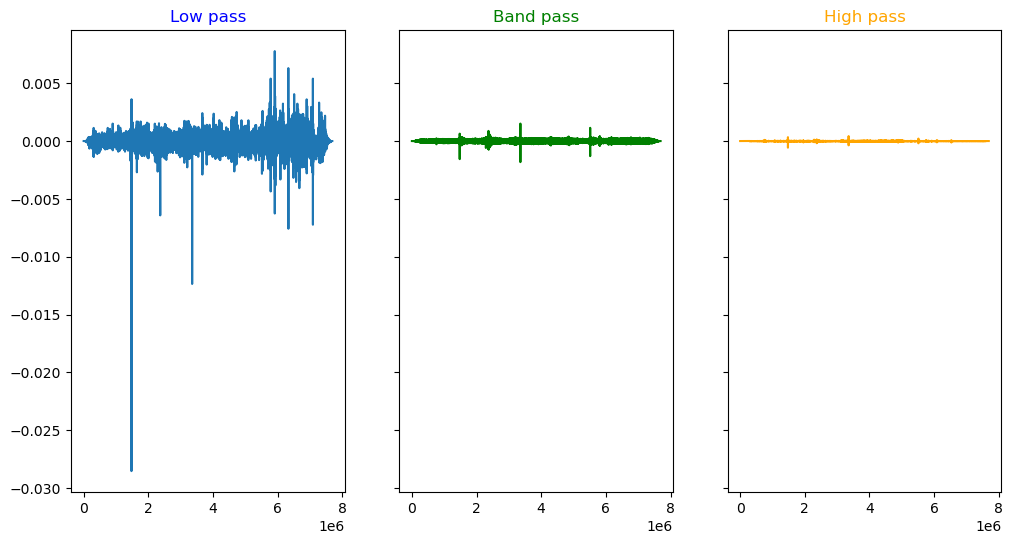

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12,6),sharey=True)

axs[0].plot(t, lp, label='low pass')
axs[0].set_title('Low pass', color='blue')
axs[1].plot(t, bp, label='band pass', c='g')
axs[1].set_title('Band pass', color='green')
axs[2].plot(t, hp, label='high pass', c='orange')
axs[2].set_title('High pass', color='orange')


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

In [3]:
# import FFT modules
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
# run fast fourier transform
Nfft = next_fast_len(int(Z[0].data.shape[0]))
# get freqs
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
# taper by 5%
Z[0].taper(max_percentage=0.05)
# fourier value 
Zhat = fft(Z[0].data,n=Nfft)

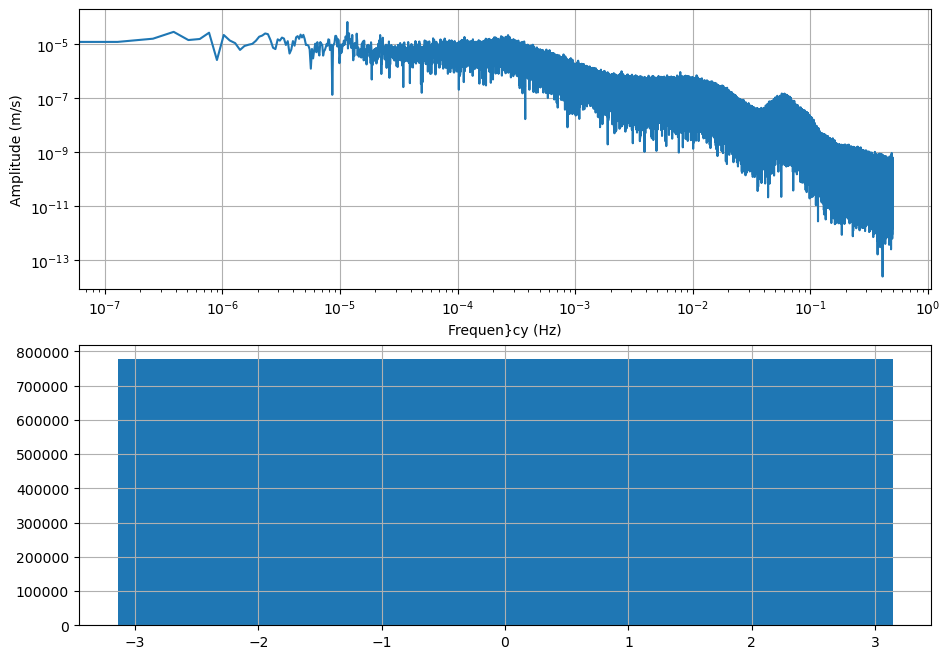

In [6]:
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)

Angle is uniformly distributed

In [12]:
np.abs(Zhat[:Nfft//2])/Nfft

array([9.16744219e-07, 1.22921952e-05, 1.61621159e-05, ...,
       6.02397445e-11, 2.72982436e-11, 1.70852439e-10])

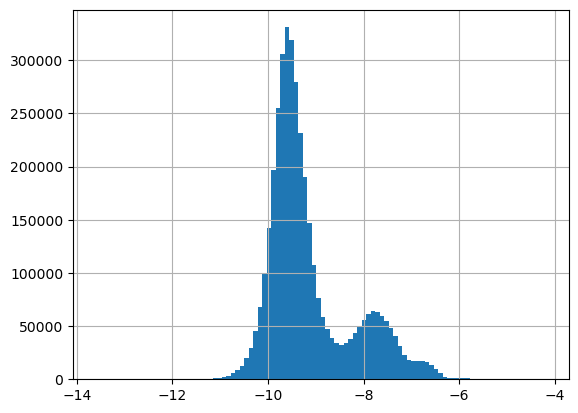

In [18]:
# Plot the histograms of the phase and amplitude spectrum
plt.hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100);plt.grid(True)
plt.show()

### Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?



The bandpass filter amplitude is 10^-11-10^-6, which corresponds to the big peak in the histogram (signal at this frequency whihc is covered by noise, which is from the low frequency stuff)

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

In [4]:
# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 

# make uniform distribution of noise in fourier space with same length as 
randphase = random.uniform(-np.pi, np.pi, size=len(Zhat))
# create fourier values from noise with same magnitude as Zhat
Nhat = np.abs(Zhat) * (np.cos(randphase)+ 1j * np.sin(randphase))
# run inverse fft to be in time domain
N = ifft(Nhat)

**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

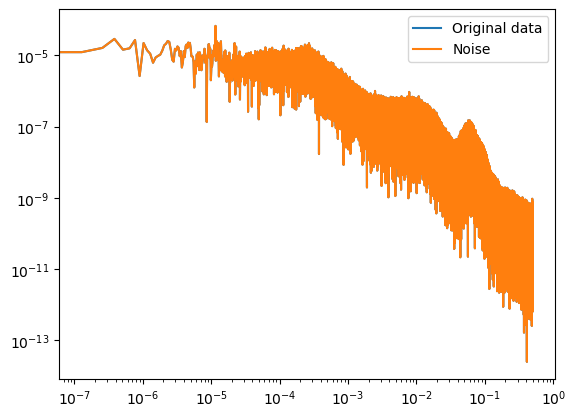

In [5]:
# answer below
Nfft = next_fast_len(int(N.data.shape[0]))
# get freqs
freqVec = fftfreq(Nfft, d=1.0)[:Nfft//2]
# Zhat
plt.loglog(freqVec,np.abs(Zhat[:Nfft//2])/Nfft, label='Original data')
# Nhat
plt.loglog(freqVec, np.abs(Nhat[:Nfft//2])/Nfft, label='Noise')
plt.legend()
## Original data and noise look the same

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

In [4]:
# answer below
from scipy.signal import stft

fs = Z[0].stats.sampling_rate
# calculate stft for the data?
f, t, Zxx = stft(z, fs=fs, nperseg=1e4)

Text(0.5, 1.0, 'Log10 Amplitude')

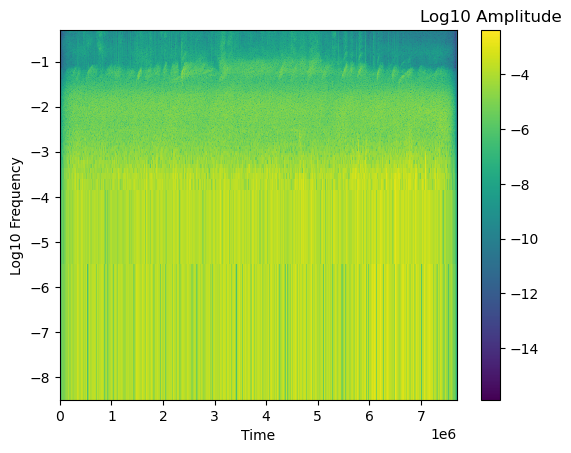

In [5]:
fig = plt.figure()
# add a very small number to log10 so it doesn't error out
cax = plt.pcolormesh(t, np.log10(f+1e-7), np.log10(np.abs(Zxx)))
cb = fig.colorbar(cax, )

plt.xlabel('Time')
plt.ylabel('Log10 Frequency')
cb.ax.set_title('Log10 Amplitude')

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [13]:
# answer below
filename='TEC/ioncorr_samo_015_2022_tonga.csv'
tonga_gps = pd.read_csv(filename)
tonga_gps['seconds'] = tonga_gps['time']
# convert to datetime
tonga_gps['time']=pd.to_datetime(tonga_gps['time'], unit='s')
# sort data so that its in order by time
tonga_gps=tonga_gps.sort_values(by='time')
# grab first 2 hours of data
sub_2H = tonga_gps.set_index('time').first('2H').reset_index()

Text(0, 0.5, 'TEC')

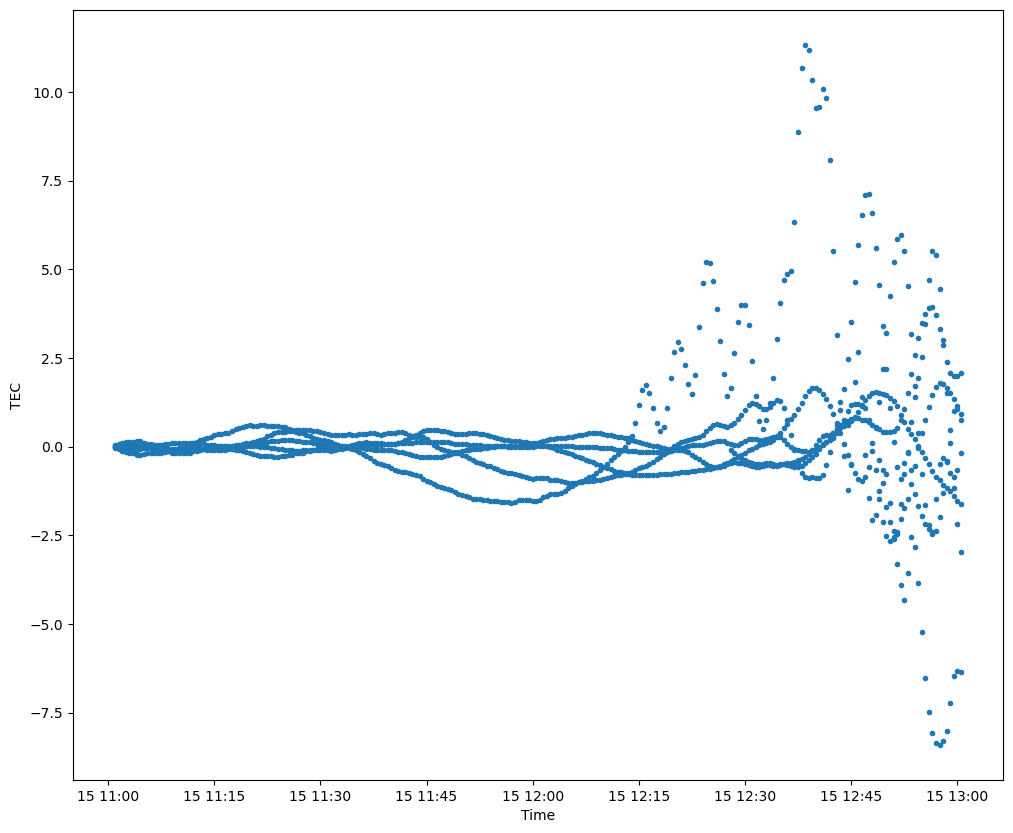

In [3]:
fig, axs = plt.subplots(figsize=(12,10))
x = sub_2H['time']
y = sub_2H['variometric_derived_TEC']

axs.plot(x,y, marker='.', linestyle='')
axs.set_xlabel('Time')
axs.set_ylabel('TEC')

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [6]:
# answer below
station_info = filename.split('_')[1]

## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

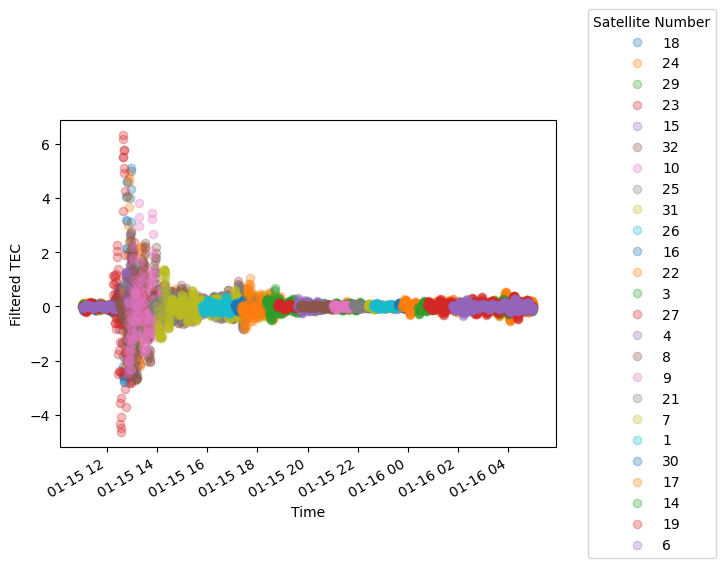

In [7]:
# answer below
tonga_gps['time']=tonga_gps['time'].values.astype('datetime64[s]')
# make figure
fig = plt.figure()
# loop thru satellites
for n in pd.unique(tonga_gps['satellite_number']):
    # get subset of data 
    sub_sat = tonga_gps.loc[tonga_gps['satellite_number']==n]
    # plot
    plt.plot_date(sub_sat['time'], 
                  sub_sat['variometric_derived_TEC_filtered'], 
                  label=n, alpha=0.3)

# set labels
plt.xlabel('Time')
plt.ylabel('Filtered TEC')
fig.autofmt_xdate()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          title='Satellite Number')

You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. What can you tell about the time-frequency characteristic of these disturbances?

In [14]:
# let's group by time instead of picking one satellite
# mean might better represent data
mean_TEC=tonga_gps.groupby(['seconds']).agg({
    'variometric_derived_TEC_filtered':'mean'})
samp_rate=mean_TEC.index.to_series().diff().value_counts().index[0]

Perform the wavelet transform.
Calculate the sampling frequency by taking the time difference between two samples.

In [15]:
# answer below
t = mean_TEC.reset_index()['seconds']
fs=1/samp_rate
z = mean_TEC.reset_index()['variometric_derived_TEC_filtered']
# use the number of scales
w = 10

# relate scales with frequencies in logspace
freq = np.logspace(-1, np.log10(fs/2), 100)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(z, signal.morlet2, widths, w=w)

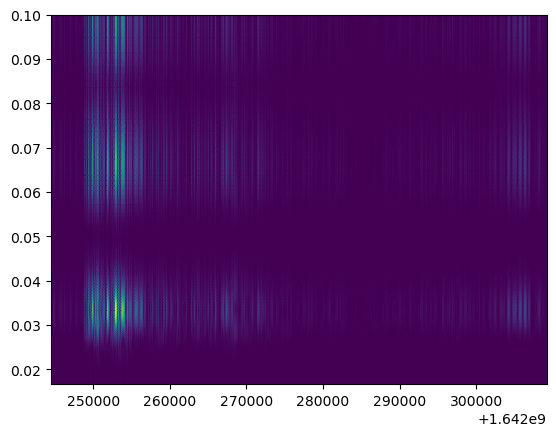

In [26]:
plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
plt.show()

## d. Wavelet transform (3 points)
You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

In [16]:
import scipy.signal as signal
# use the number of scales
w = np.arange(1, 51)

# answer below
freq = np.logspace(-1, np.log10(fs/2), len(w))
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(z, signal.morlet2, widths, w=w)

ValueError: operands could not be broadcast together with shapes (50,) (2,) 

I could not figure out how to do this section, but I would love to know what I'm doing wrong! 

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

The largest packet occurred around 69.4 hours (250000 seconds), and a second one occurred around 80 hours (300000 seconds) according to the mean of all the satellites. This lamb wave lasted until 76.4 hours (275000) and had three dominanting frequencies around 0.03-0.04, 0.06-0.08, and 0.9-1.0 Hz. These were reflected in the potential tsunami disturbance hours later. 

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc`` and ``NCM_SpatialGrid.nc``.


In the following we will prepare our data.

In [28]:
!pip install wget
import wget
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"

  Using cached wget-3.2-py3-none-any.whl


In [2]:
# ansert below
import netCDF4 as nc

# read data
geology = nc.Dataset('NCM_GeologicFrameworkGrids.nc')
grid = nc.Dataset('NCM_SpatialGrid.nc')
aux = nc.Dataset('NCM_AuxData.nc')

**a. Plot (2 points)**

Plot the data WT and elevation, which are data sets from the NC files. Use the matplotlib functioncontourf, and the variables for lat long x and y . You can use the argument levels to the contourf funxtion to split the color map into discrete contour levels, and the transparency argument alpha to be less than 1.

In [8]:
aux['Water Table Depth']

<class 'netCDF4._netCDF4.Variable'>
float32 Water Table Depth(dim2, dim1)
unlimited dimensions: 
current shape = (4901, 3201)
filling on, default _FillValue of 9.969209968386869e+36 used

In [9]:
aux.variables.keys()

dict_keys(['Water table depth file', 'Slopes file', 'Notes', 'Water Table Depth', 'Calibration Slope', 'Calibration Offset'])

In [7]:
# answer below
# create a grid of latitude and longitude
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
elevation = geology['Surface Elevation'][0:4901, 0:3201]
wt = aux['Water Table Depth'][0:4901, 0:3201]

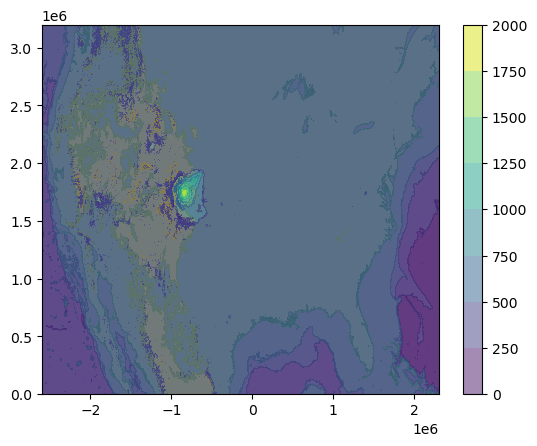

In [16]:
# plot below
plt.contourf(x, y, elevation, alpha=0.7)
cax=plt.contourf(x, y, wt, alpha=0.5)
cb = plt.colorbar(cax)

**b. Perform and plot the 2D Fourier transforms (4 points)**

In [8]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm

# recreate the lat long vectors.
minlat,maxlat = min(grid['Latitude vector'][:]),max(grid['Latitude vector'][:])
minlon,maxlon = min(grid['Longitude vector'][:]),max(grid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

In [9]:
from scipy.fftpack import fft2, fftfreq,fftshift, ifft2
import matplotlib.cm as cm
Zel = fft2(elevation)
Zwt = fft2(wt)

# make a vector of distances. Here I will ignore the curvature and spatial projection.
# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


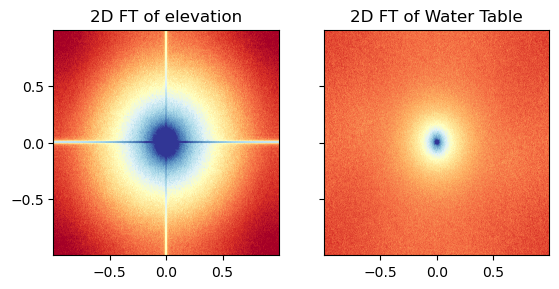

In [13]:
fig, axs = plt.subplots(1,2, sharey=True)

# amplitude of the DEM
axs[0].imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
axs[0].set_title('2D FT of elevation')
axs[0].set_xticks([-0.5,0,0.5])
axs[0].set_yticks([-0.5,0,0.5])

# amplitude of the Water table
axs[1].imshow(fftshift(np.log10(np.abs(Zwt)/Zwt.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
axs[1].set_title('2D FT of Water Table')
axs[1].set_xticks([-0.5,0,0.5])
axs[1].set_yticks([-0.5,0,0.5])

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths.

The DEM is dominated by more wavelengths in the North, East, South, West directions while the water table depth is not. There is a higher gradient of change in wavelength for elevation as well, in comparison to the water table depth. This makes sense there is likely more change in elevation than there is for water table depth. 

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [10]:
# solution
Zsort_el = np.sort(np.abs(np.abs(Zel).reshape(-1)))
Zsort_wt = np.sort(np.abs(np.abs(Zwt).reshape(-1)))

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

We are keeping up to 0.010000 the number of Fourier coefficients


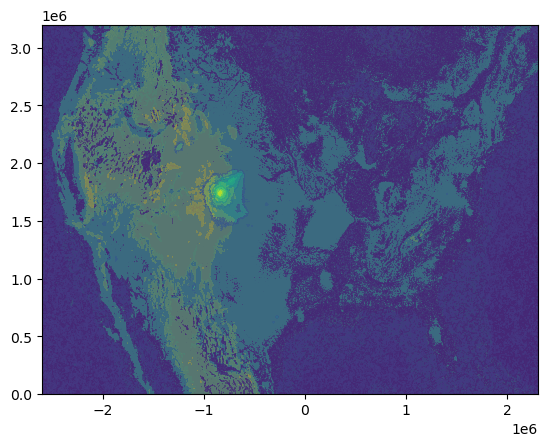

In [11]:
#asnwer below
from IPython import display
import time

from IPython import display
import time
for keep in (0.1,0.05,0.01):
    display.clear_output(wait=True)
    thresh = Zsort_wt[int(np.floor( (1-keep)*len(Zsort_wt) ))]
    ind = np.abs(Zel)>thresh
    Atlow = Zwt * ind # here we zero out the matrix
    # Here we count the number of non-zeros in the matrix
    print("We are keeping up to %f the number of Fourier coefficients" % keep)
    Alow = ifft2(Atlow).real
    plt.contourf(x, y, elevation, alpha=0.7)
    plt.contourf(x, y, Alow, alpha=0.5)
    time.sleep(1)

Now we will compare the original 2D data set with the Fourier compressed data


The compressed image still has the same high point around the same area as the original data. There are some more artificats that are likely a result of the compression, but the overall image is very similar when overlaid with the original DEM. The most important Fourier coefficients represent the water table well in this use case. 